In [ ]:
#Image captioning using transfer learning




import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [ ]:
#to get to know how much time it will take

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [ ]:
root_captioning = "content/Drive/My Drive/data/captions"

In [ ]:
 #this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
root_captioning  = '/content/drive/My Drive/data/captions/'
assert root_captioning  is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(root_captioning ))

Mounted at /content/drive


In [ ]:
#cleanup dataset from flicker..........................


null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text',\
                        'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]#lower case all the word
      desc = [w.translate(null_punct) for w in desc]#removing punctution
      desc = [word for word in desc if len(word)>1]#remove shorter words
      desc = [word for word in desc if word.isalpha()]#remove words which do not have alphabetic letter
      max_length = max(max_length,len(desc))#assigning maximum caption size
      
      #build up dictionary of these
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [ ]:
print(len(lookup)) # How many unique words
print(len(lex)) # The number of words in a dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


In [ ]:
#glove embeddings


#Glove embeddings are vectors for each of the words in the vocabulary-----these are the features which will put in neural network
#for prediction

In [ ]:

# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [ ]:
len(img)

8091

In [ ]:
#Read all image names and use the predefined train/test sets.


train_images_path = os.path.join(root_captioning,\
            'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [ ]:
print(len(train_images))
print(len(test_images))

6000
1000


In [ ]:
#Build the sequences. We include a start and stop token at the beginning/end. We will later use the start token to begin the process of generating
# a caption. Encountering the stop token in the generated text will let us know the process is complete.

train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [ ]:
#Choosing a Computer Vision Neural Network to Transfer(using transfer learning)

#This example provides two neural networks that we can use via transfer learning. In this example, 
#I use Glove for the text embedding and InceptionV3 to extract features from the images. Both of these transfers serve
# to extract features from the raw text and the images. Without this prior knowledge transferred in, this example would take considerably more training.

#I made it so you can interchange the neural network used for the images. By setting the values WIDTH, HEIGHT, and OUTPUT_DIM,
# you can interchange images. One characteristic that you are seeking for the image neural network is that it does not have too many outputs 
#(once you strip the 1000-class imagenet classifier, as is common in transfer learning). InceptionV3 has 2,048 features below the classifier,
# and MobileNet has over 50K. If the additional dimensions truly capture aspects of the images, then they are worthwhile. However, having 50K 
#features increases the processing needed and the complexity of the neural network we are constructing.

In [ ]:

if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96116736/96112376 [==============================] - 7s 0us/step


In [ ]:

encode_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
#Creating the Training Set


#We need to encode the images to create the training set. Later we will encode new images to present them for captioning.

In [ ]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image 
  # encoding network),without taking care of aspect ratio..transferred neaural network would take care of that.
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array..
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array....(convert the string of images into the grid)
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others transfer learning neaural network
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for 
  # the image and predict.

  x = encode_model.predict(x) # Get the encoding vector for the image

  # Shape to correct form to be accepted by LSTM captioning network((so that it would be of right size(2048 for inception v3) for the input of neural network)).
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [ ]:
#We can now to generate the training set, which will involve looping over every JPG that we provided. Because this can take a while
# to perform, we will save it to a pickle file. This saved file prevents the considerable time needed to reprocess all of the images again.
#  Because the images are processed differently by different transferred neural networks, the filename contains the output dimensions.
 #We follow this naming convention because if you changed from 
#InceptionV3 to MobileNet, the number of output dimensions would change, and you must reprocess the images.

In [ ]:
train_path = os.path.join(root_captioning,'Flicker8k_Dataset',f'Flickr_8k.trainImages')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [ ]:
#We must also perform a similar process for the test images.

In [ ]:
test_path = os.path.join(root_captioning,'Flicker8k_Dataset',f'Flickr_8k.testImages')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

In [ ]:
#Next, we separate the captions that we will use for training. There are two sides to this training, the images, and the captions.

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)
#there are 5 captions for each image in dataset

30000

In [ ]:
#Words that do not occur very often can be misleading to neural network training. It is better to remove such words. Here we remove any words that occur less than ten times.
 #We display the new reduced size of the vocabulary shrunk.

In [ ]:

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))


#now we have 1651 words in our vocabulory

preprocessed words 7578 ==> 1651


In [ ]:
#Next, we build two lookup tables for this vocabulary. The table idxtoword converts index numbers to actual words to index values. 
#The wordtoidx lookup table performs the opposite.

In [ ]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [ ]:
#Previously we added a start and stop token to all sentences. We must account for this in the maximum length of captions.


max_length +=2
print(max_length)

34


In [ ]:
#we would have to duplicate the image for each of these partial captions that we have. Additionally, the Flikr8K data set has five captions for each picture.
# Those would all require duplication of data as well. 
#It is much more efficient to generate the data as needed.

In [ ]:
#what data generator do is it's looping all the keys of all the essential images we have and also looping descrition with them,and each image has 5 
#description


def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0
#As there is a lot of data is looping so the yield command is used which freeze the remaining loop once we get result and next when it uses
# ,it would restart from where it got freezed




In [ ]:

#Loading Glove Embeddings---which converts the words in vector


glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:24, 16154.70it/s]

Found 400000 word vectors.


In [ ]:
#We now build the inputs for all the captions we have:


embedding_dim = 200#we can't change this 200 as fixed by glove

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:

embedding_matrix.shape

(1652, 200)

In [ ]:
#Above matrix dimensions make sense. It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [ ]:
#Neural Network


inputs1 = Input(shape=(OUTPUT_DIM,))#input 1 would be your image
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))#input 2 would be our gradually increasing caption which we are going to send each time
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)#this is an embedded layer which uses vocablry size and embedded dim,embedding matrix 
#would be your weights  for this layer add in further code
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:

embedding_dim

200

In [ ]:

caption_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:

caption_model.layers[2].set_weights([embedding_matrix])#set embedded matrix as weights of neural network
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#Train the Neural Network


In [ ]:
#Batch size=3
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
#20 epchs for 1e-4 learning rate and then learning rate would decrease gradually for remaing epochs


model_path = os.path.join(root_captioning,'Flicker8k_Dataset',f'CrowdFlowerAnnotations')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  #print(f"\Training took: {hms_string(time()-START)}")
else:
  caption_model.load_weights(model_path)

  0%|          | 0/20 [00:00<?, ?it/s]

1000/1000 [==============================] - 83s 83ms/step - loss: 2.2102


  5%|▌         | 1/20 [01:23<26:27, 83.57s/it]

1000/1000 [==============================] - 83s 83ms/step - loss: 2.2060


 10%|█         | 2/20 [02:46<24:59, 83.30s/it]

1000/1000 [==============================] - 82s 82ms/step - loss: 2.2058


 15%|█▌        | 3/20 [04:07<23:27, 82.81s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.2061


 20%|██        | 4/20 [05:28<21:55, 82.22s/it]

1000/1000 [==============================] - 80s 80ms/step - loss: 2.2026


 25%|██▌       | 5/20 [06:49<20:25, 81.73s/it]

1000/1000 [==============================] - 80s 80ms/step - loss: 2.2021


 30%|███       | 6/20 [08:09<18:59, 81.36s/it]

1000/1000 [==============================] - 80s 80ms/step - loss: 2.1973


 35%|███▌      | 7/20 [09:30<17:33, 81.05s/it]

1000/1000 [==============================] - 80s 80ms/step - loss: 2.1976


 40%|████      | 8/20 [10:50<16:09, 80.78s/it]

1000/1000 [==============================] - 80s 80ms/step - loss: 2.1939


 45%|████▌     | 9/20 [12:10<14:47, 80.64s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1963


 50%|█████     | 10/20 [13:31<13:26, 80.68s/it]

1000/1000 [==============================] - 80s 80ms/step - loss: 2.1931


 55%|█████▌    | 11/20 [14:51<12:04, 80.55s/it]

1000/1000 [==============================] - 80s 80ms/step - loss: 2.1915


 60%|██████    | 12/20 [16:12<10:44, 80.57s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1918


 65%|██████▌   | 13/20 [17:33<09:24, 80.66s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1875


 70%|███████   | 14/20 [18:54<08:04, 80.79s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1873


 75%|███████▌  | 15/20 [20:15<06:44, 80.84s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1865


 80%|████████  | 16/20 [21:36<05:23, 80.86s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1850


 85%|████████▌ | 17/20 [22:57<04:03, 81.05s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1846


 90%|█████████ | 18/20 [24:18<02:42, 81.06s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1827


 95%|█████████▌| 19/20 [25:39<01:21, 81.12s/it]

1000/1000 [==============================] - 81s 81ms/step - loss: 2.1807


100%|██████████| 20/20 [27:01<00:00, 81.08s/it]

   1/1000 [..............................] - ETA: 1s - loss: 2.1724

1000/1000 [==============================] - 83s 83ms/step - loss: 2.1652


In [ ]:
#Generating Captions
#It is essential to understand that we do not generate a caption with one single call to the neural network's predict function.
#Neural networks output a fixed-length tensor. To get a variable-length output, such as free-form text, requires multiple calls to the neural network.

#The neural network accepts two objects (which we map to the input neurons). The first input is the photo, and the second input is an ever-growing caption.
 #The caption begins with just the starting token. The neural network's output is the prediction of the next word in the caption. 
 #The caption continues to grow until the neural network predicts an end token, or we reach the maximum length of a caption.

In [ ]:

def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)#it would give the prediction
        yhat = np.argmax(yhat)#it would give only that which would have highest prediction(probabilty)
        word = idxtoword[yhat]
        in_text += ' ' + word# for adding space betweeen the word
        if word == STOP:#for stopping the caption
            break
    final = in_text.split()#and finally it will splits the textual string to return the caption
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
#Evaluate Performance on Test Data from Flicker8k

/content/drive/My Drive/data/captions/Flicker8k_Dataset/3192266178_f9bf5d3dba.jpg


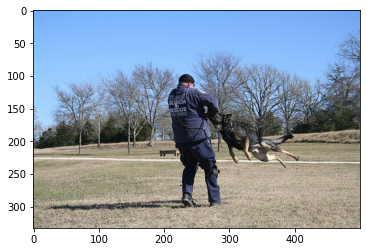

Caption: man and dog are playing with ball in field
_____________________________________
/content/drive/My Drive/data/captions/Flicker8k_Dataset/241345844_69e1c22464.jpg


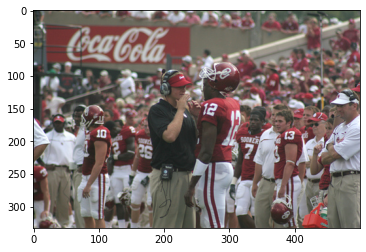

Caption: two football players in red jerseys are running on the field
_____________________________________


In [ ]:
for z in range(2): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [ ]:

encoding_test[pic].shape

(2048,)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving pic2.jpg to pic2.jpg


In [ ]:
https://tensorflow.org/images/surf.jpg

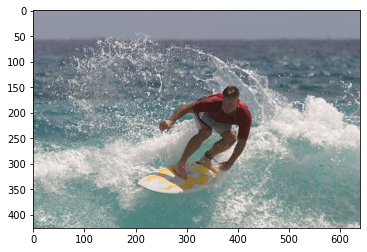

(1, 2048)
Caption: surfer in black wetsuit surfs wave
_____________________________________


In [ ]:

from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline


url = 'https://tensorflow.org/images/surf.jpg'
  


response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

plt.imshow(img)
plt.show()
  
response = requests.get(url)

img = encodeImage(img).reshape((1,OUTPUT_DIM))
print(img.shape)
print("Caption:",generateCaption(img))
print("_____________________________________")